In [1]:
##################################################
########## Loading Necessary Libraries  ##########
##################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time

In [2]:
##################################################
########### Loading and Cleaning Data ############
##################################################

# # Load data
data = pd.read_csv('data.csv')

# Extracting the target variable for final accuracy calculation
y = data['diagnosis']

In [3]:
##################################################
############### Defining Functions ###############
##################################################

##############################################
###### Functions for Mutual Information ######
##############################################
def calculate_entropy(column):
    value_counts = column.value_counts()
    non_zero_counts = value_counts[value_counts != 0]
    ent = -(non_zero_counts / len(column) * np.log2(non_zero_counts / len(column))).sum()
    return ent

def calculate_joint_entropy(column_1, column_2):
    joint_probs = column_1.groupby([column_1, column_2]).size() / len(column_1)
    joint_entropy = -(joint_probs * np.log2(joint_probs)).sum()
    return joint_entropy

def calculate_mutual_information(entropy_1, entropy_2, column_1, column_2):
    joint_entropy = calculate_joint_entropy(column_1, column_2)
    mutual_information = entropy_1 + entropy_2 - joint_entropy
    return mutual_information

def calculate_total_mi(target, data):
    mutual_information_data = []

    # Pre-calculate entropy for each column
    entropies = { 'target': calculate_entropy(target) }
    for column in data.columns:
        entropies[column] = calculate_entropy(data[column])

    for column in data.columns:
        mutual_information_data.append({'column': column, 'value': calculate_mutual_information(entropies['target'], entropies[column], target, data[column])})

    mutual_information_data_pd = pd.DataFrame(mutual_information_data)
    return mutual_information_data_pd['value'].sum()

##############################################
######## Genetic Algorithm Functions #########
##############################################

# Create a function for creating a population
def create_population(y, population_size):
    # Unique values of y
    values = y.unique()

    # Create a list to store the population
    population = []

    # Create a for loop to create the population
    for i in range(population_size):
        # Create a random individual
        individual = np.random.choice(values, size=len(y))

        # Append the individual to the population
        population.append(individual)

    return population

# Calculate the fitness of the population
def calculate_fitness(X, population):
    # Create a list to store the fitness
    fitness = []

    # Create a for loop to calculate the fitness of each individual
    for individual in population:
        # Calculate the error rate
        total_mi = calculate_total_mi(pd.DataFrame( individual, columns=['y'])['y'], X)

        # Calculate the fitness
        fitness.append(total_mi)

    # Return the fitness
    return fitness

# Select parents function
def select_parents(population, fitness):
    # Create a list to store the probability of each individual
    probability = []

    # Create a for loop to calculate the probability of each individual
    for i in fitness:
        probability.append(i / sum(fitness))

    # Select the parents
    parents = np.random.choice(len(population), size=2, replace=False, p=probability)

    # Return the parents
    return population[parents[0]], population[parents[1]]

# Cross over function
def crossover(parent1, parent2, crossover_rate):
    # Create a random number for the crossover
    crossover = np.random.random()

    # Check if the crossover is less than the crossover rate
    if crossover < crossover_rate:
        # Create a random number for the crossover point
        crossover_point = np.random.randint(0, len(parent1))

        # Create a temporary variable for parent 1
        temp_parent1 = parent1
        # Create a temporary variable for parent 2
        temp_parent2 = parent2

        # Create a child 1
        child1 = np.concatenate((temp_parent1[:crossover_point], temp_parent2[crossover_point:]))
        # Create a child 2
        child2 = np.concatenate((temp_parent2[:crossover_point], temp_parent1[crossover_point:]))

        # Return the children
        return child1, child2

    # Return the parents
    return parent1, parent2

# Mutation function
def mutation(child, mutation_rate):
    # Create a random number for the mutation
    mutation = np.random.random()

    # Check if the mutation is less than the mutation rate
    if mutation < mutation_rate:
        # Create a random number for the mutation point
        mutation_point = np.random.randint(0, len(child))

        # Create a temporary variable for child
        temp_child = child

        # Create a list of unique values
        unique_values = np.unique(temp_child)

        # Create a list of values that are not equal to the mutation point
        values = [i for i in unique_values if i != temp_child[mutation_point]]

        # Create a random value
        random_value = np.random.choice(values)

        # Mutate the child
        temp_child[mutation_point] = random_value

        # Return the child
        return temp_child

    # Return the child
    return child

# Define a function for running the genetic algorithm
def run_genetic_algorithm(data, population_size, max_generation, mutation_rate, crossover_rate):
    ##### Preprocessing the data #####
    X = data.drop(['id', 'diagnosis','Unnamed: 32'], axis=1)
    y = data['diagnosis']

    # Cleaning the data 
    corr = X.corr()
    corr_t = corr.abs().unstack()
    corr_t = corr_t.sort_values(kind="quicksort")
    col_to_drop = []
    for i in range(1, len(corr_t)):
        if corr_t[i] > 0.9 and corr_t.index[i][0] != corr_t.index[i][1]:
            col_to_drop.append([corr_t.index[i][0], corr_t.index[i][1]])
    # Calculate total correlation of each column in col_to_drop
    total_corrs = corr.abs().sum(axis=1).sort_values(ascending=False)
    droped_cols = []
    for i in col_to_drop:
        if(i[0] in droped_cols or i[1] in droped_cols):
            continue
        elif total_corrs[i[0]] > total_corrs[i[1]]:
            X.drop(i[1], axis=1, inplace=True)
            droped_cols.append(i[1])
        else:
            X.drop(i[0], axis=1, inplace=True)
            droped_cols.append(i[0])

    max_correlation = 5
    corr = X.corr()
    # Choose the highest correlation columns
    highest_corr_col = corr.abs().sum(axis=1).sort_values(ascending=False).head(1)
    while(highest_corr_col[0] > max_correlation):
        # Drop the highest correlation columns
        X = X.drop(highest_corr_col.index, axis=1)
        corr = X.corr()
        highest_corr_col = corr.abs().sum(axis=1).sort_values(ascending=False).head(1)

    ##### Running the genetic algorithm #####

    # Create initial population
    population = create_population(y, population_size)
    # Creating fields to store all time best and its fitness
    all_time_best = []
    all_time_best_fitness = 0
    all_time_database = []

    # Create a for loop to run the genetic algorithm
    for i in range(0, max_generation):
        print("Generation " + str(i+1) + " ...   ", end="\r")

        # Calculate the fitness of the population
        fitness = calculate_fitness(X, population)

        # Check if the fitness of the population is greater than the all time best fitness
        if np.max(fitness) > all_time_best_fitness:
            all_time_best_fitness = np.max(fitness)
            all_time_best = population[np.argmax(fitness)]

        # Add population and fitness to all_time_database
        for j in range(len(population)):
            all_time_database.append([population[j], fitness[j]])

        # Create a list to store the new population
        new_population = []

        # A for loop to create a new population
        for j in range(0, int(population_size/2)):
            # Select two parents
            parent1, parent2 = select_parents(population, fitness)
            # Crossover
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            # Mutation
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            # Add child1 and child2 to new_population
            new_population.append(child1)
            new_population.append(child2)
        # Replace the population with new_population
        population = new_population

    # Return the all time best and its fitness
    return all_time_best, all_time_best_fitness, all_time_database

##############################################
##### Functions for Calculating Accuracy #####
##############################################

def calculate_accuracy(y, predicted_y):
    # Get the length of y
    n = len(y)

    # Create a for loop to calculate accuracy
    accuracy = 0
    for i in range(0, n):
        if y[i] == predicted_y[i]:
            accuracy = accuracy + 1

    # Return accuracy
    return accuracy/n

##############################################
########### Defining Run Function ############
##############################################

#Function to run the genetic algorithm with multiple configurations
def multi_run(run_configuration, data, y):
    all_individuals = []

    # Create a list to store the accuracy
    results = []
    print("Running the genetic algorithm, for " + str(len(run_configuration)) + " runs ...")
    # A for loop to run the genetic algorithm multiple times
    for i in range(0, len(run_configuration)):
        print("Run " + str(i+1) + " ...          ")

        # Set start time
        start_time = time.time()

        # Run the genetic algorithm
        all_time_best, all_time_best_fitness, all_time_database = run_genetic_algorithm(data, run_configuration[i]['population_size'], run_configuration[i]['max_generation'], run_configuration[i]['mutation_rate'], run_configuration[i]['crossover_rate'])

        # Accuracy calculation
        accuracy = calculate_accuracy(y, all_time_best)

        mid_time = time.time()

        # Go through the all_time_database to get all the individuals, if the individual is not in all_individuals, add it to all_individuals with its fitness and calculated accuracy)
        for j in range(0, len(all_time_database)):
            all_individuals.append([all_time_database[j][0], all_time_database[j][1], calculate_accuracy(y, all_time_database[j][0]), i])

        # Set end time
        first_half_time = mid_time - start_time
        second_half_time = time.time() - mid_time

        # update the results, append the configuration and the accuracy, destructure the configuration
        results.append({
            **run_configuration[i],
            'accuracy': accuracy,
            'all_time_best': all_time_best,
            'all_time_best_fitness': all_time_best_fitness,
            'first_half_time': first_half_time,
            'second_half_time': second_half_time
        })
    print("Done!                              ")
    # Return the accuracy
    return results, all_individuals

In [4]:
##################################################
################## Run the code ##################
##################################################

run_configuration = [
    {
        'population_size': 300,
        'max_generation': 1500,
        'mutation_rate': 0.2,
        'crossover_rate': 0.8
    },
    {
        'population_size': 300,
        'max_generation': 2000,
        'mutation_rate': 0.2,
        'crossover_rate': 0.8
    },
    {
        'population_size': 300,
        'max_generation': 2500,
        'mutation_rate': 0.2,
        'crossover_rate': 0.8
    },
]

results, all_individuals = multi_run(run_configuration, data, y)

# Set the test time end
test_time_end = time.time()

Running the genetic algorithm, for 3 runs ...
Run 1 ...          
Run 2 ...             
Run 3 ...             
Done!                              


In [5]:
##################################################
############ Processing results data #############
##################################################

# Export run_configuration to a csv file
run_configuration_df = pd.DataFrame(run_configuration)
run_configuration_df.to_csv('mi_results/MI-run_configuration-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.csv', index=False)

# Create a chart to show the results
results_df = pd.DataFrame(results)
results_df = results_df.drop(['all_time_best'], axis=1)
results_df = results_df.sort_values(by=['accuracy'], ascending=False)
results_df = results_df.reset_index(drop=True)

# Export the results to a csv file
results_df.to_csv('mi_results/MI-results-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.csv', index=False)

# Display the results
results_df

,population_size,max_generation,mutation_rate,crossover_rate,accuracy,all_time_best_fitness,first_half_time,second_half_time
0,100,1500,0.2,0.8,0.523726,10.889611,3781.370099,227.640251
1,100,2000,0.2,0.8,0.521968,10.897263,4621.751114,227.236284
2,100,1000,0.2,0.8,0.509666,10.901745,2583.303083,111.941176


Total number of unique individuals: 450000


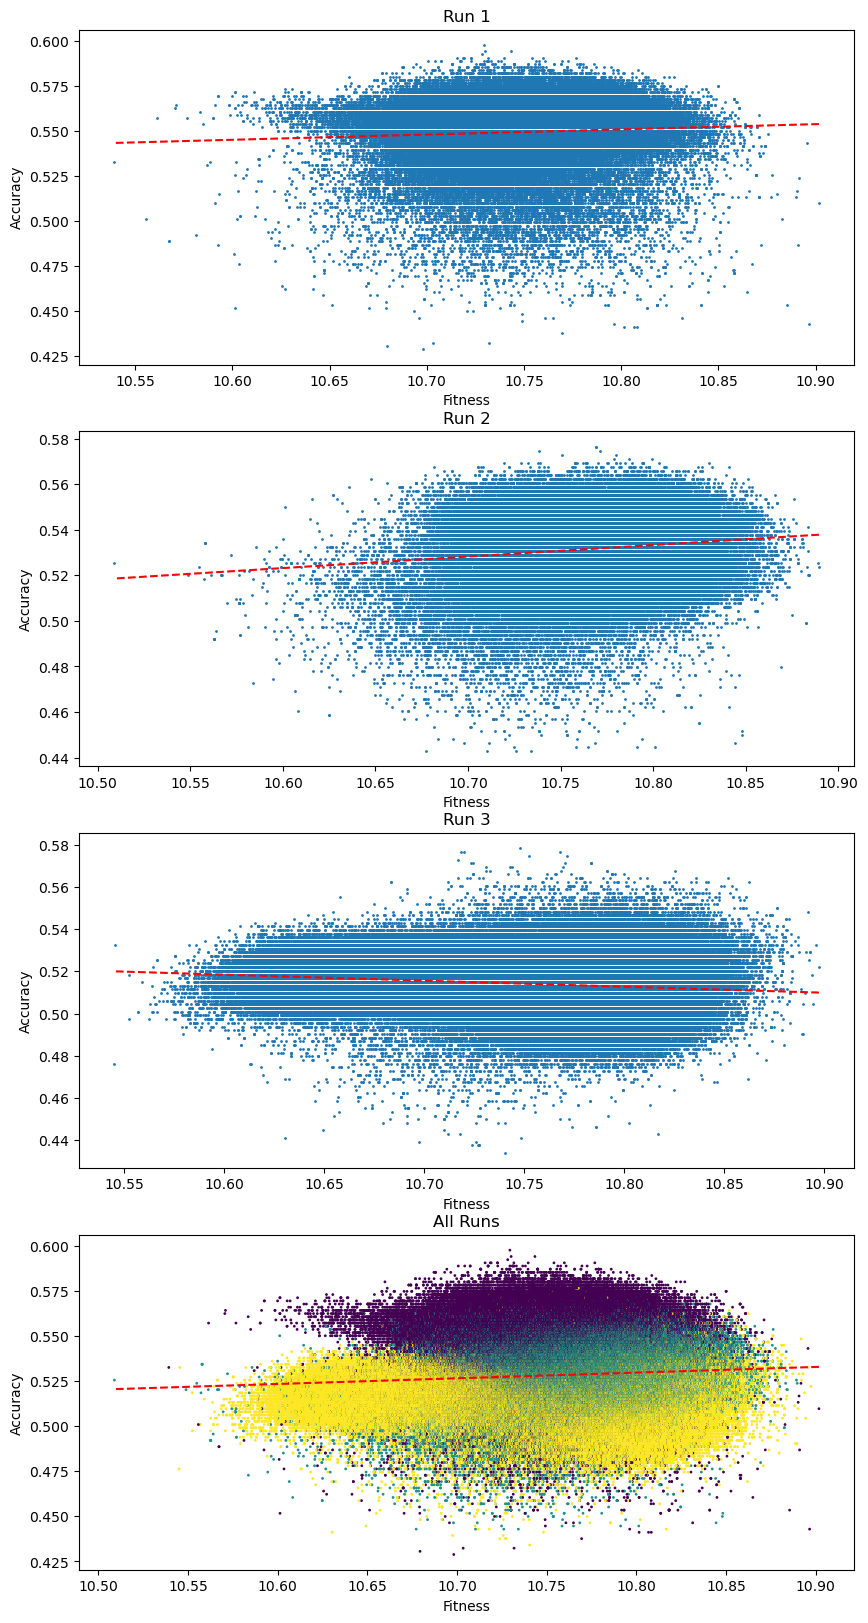

In [6]:
##################################################
########### Plotting all_individuals #############
##################################################

# Create a chart to show all_individuals with their fitness and accuracy as axes
all_individuals_df = pd.DataFrame(all_individuals, columns=['individual', 'fitness', 'accuracy', 'run'])
all_individuals_df = all_individuals_df.sort_values(by=['fitness'], ascending=False)
all_individuals_df = all_individuals_df.reset_index(drop=True)

# Export the all_individuals to a csv file
all_individuals_df.to_csv('mi_results/MI-all_individuals_list-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.csv', index=False)

# Print total number of unique individuals
print("Total number of unique individuals: " + str(len(all_individuals_df)))

# Plot all_individuals_df and fit a line, colorized by number of run
# Create subplots for each run and one for all runs
# For each of them, fit a line and plot the scatter plot

fig, axs = plt.subplots(len(run_configuration) + 1, 1, figsize=(10, 20))

for i in range(len(run_configuration)):
    axs[i].scatter(all_individuals_df[all_individuals_df['run'] == i]['fitness'], all_individuals_df[all_individuals_df['run'] == i]['accuracy'], s=1)
    z = np.polyfit(all_individuals_df[all_individuals_df['run'] == i]['fitness'], all_individuals_df[all_individuals_df['run'] == i]['accuracy'], 1)
    p = np.poly1d(z)
    axs[i].plot(all_individuals_df[all_individuals_df['run'] == i]['fitness'], p(all_individuals_df[all_individuals_df['run'] == i]['fitness']), "r--")
    axs[i].set_xlabel('Fitness')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title('Run ' + str(i+1))

# Plotting all runs
axs[len(run_configuration)].scatter(all_individuals_df['fitness'], all_individuals_df['accuracy'], c=all_individuals_df['run'], s=1)
z = np.polyfit(all_individuals_df['fitness'], all_individuals_df['accuracy'], 1)
p = np.poly1d(z)
axs[len(run_configuration)].plot(all_individuals_df['fitness'], p(all_individuals_df['fitness']), "r--")
axs[len(run_configuration)].set_xlabel('Fitness')
axs[len(run_configuration)].set_ylabel('Accuracy')
axs[len(run_configuration)].set_title('All Runs')

# Export the plot to a png file, name: all_individuals-DATE-TIME.png
plt.savefig('mi_results/MI-all_individuals_chart-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.png')
